# Facebook Social Circles V2
Link: https://snap.stanford.edu/data/ego-Facebook.html

>This dataset consists of 'circles' (or 'friends lists') from Facebook. Facebook data was collected from survey participants using this Facebook app.

---

Focus: Integrating node-level features with scaled Logistic Regression; optimizing via basic hyperparameter tuning.

In [1]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
import sys
sys.path.append('../')

from utils import negative_sampling as ns, splits, plot

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score


## Dataset Loading

This dataset is an ego network, meaning that it centers around a specific user (the "ego") and includes all their immediate friends and the connections between those friends.
There are several file types:
- `.edges`: These files define the edges within a specific ego network.
- `.feat`: These files contain anonymized binary features for all nodes in the ego network (except the ego itself). Each line starts with a node ID, followed by a series of binary (0 or 1) feature values, space-separated.
- `.egofeat`: These files contain the anonymized binary features for the ego node itself.
- `.featnames`: Provides a mapping for the feature indices. Each line describes a feature. Due to anonymization, the descriptions are generic.
- `.circles`: Defines "circles" or "friend lists" within the ego network (ground-truth communities). Each line starts with a label, followed by a list of space-separated node IDs that belong to that circle. 

For learning purposes this notebook will focus on just one ego network (of node `0`) from all the ego networks available in the dataset.

In [2]:
# Load Graph
G = nx.read_edgelist('data/0.edges', nodetype=int)

In [3]:
# Load Features Names
feature_path = 'data/0.feat'
feature_names_path = 'data/0.featnames'
egofeat_path = "data/0.egofeat"

feature_names = []
try:
    with open(feature_names_path, 'r') as f:
        for line in f:
            line = line.strip()
            parts = line.split(' ', 1)  # Separate indexes
            feature_names.append(parts[1])
except Exception as e:
    print(f"An error occurred while loading feature names: {e}")
    feature_names = []

feature_names[:10]

['birthday;anonymized feature 0',
 'birthday;anonymized feature 1',
 'birthday;anonymized feature 2',
 'birthday;anonymized feature 3',
 'birthday;anonymized feature 4',
 'birthday;anonymized feature 5',
 'birthday;anonymized feature 6',
 'birthday;anonymized feature 7',
 'education;classes;id;anonymized feature 8',
 'education;classes;id;anonymized feature 9']

Feature vectors from this dataset has been obscured, so each feature real value has been replaced. For instance, a feature "political=Democratic Party", would be replaced with "political=anonymized feature 1".

In [4]:
# Load Features Values
node_ids = []
feature_data_rows = []
expected_num_features = len(feature_names)

try:
    with open(feature_path, 'r') as f:
        for line in f:
            line = line.strip()
            parts = line.split(' ')

            node_id = int(parts[0])

            feat_values = [int(val) for val in parts[1:]]

            node_ids.append(node_id)
            feature_data_rows.append(feat_values)

except Exception as e:
    print(f"An error occurred while loading feature data: {e}")

# Create Dataframe
features_df = pd.DataFrame(feature_data_rows, columns=feature_names, index=node_ids)
features_df.head(10)

,birthday;anonymized feature 0,birthday;anonymized feature 1,birthday;anonymized feature 2,birthday;anonymized feature 3,birthday;anonymized feature 4,birthday;anonymized feature 5,birthday;anonymized feature 6,birthday;anonymized feature 7,education;classes;id;anonymized feature 8,education;classes;id;anonymized feature 9,...,work;start_date;anonymized feature 200,work;start_date;anonymized feature 201,work;start_date;anonymized feature 168,work;start_date;anonymized feature 202,work;start_date;anonymized feature 169,work;start_date;anonymized feature 170,work;start_date;anonymized feature 171,work;start_date;anonymized feature 203,work;start_date;anonymized feature 204,work;with;id;anonymized feature 205
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


The features DataFrame utilizes **one-hot encoding**, a technique used to represent categorical variables as binary vectors. This method converts each distinct category into a binary feature: a '1' indicates the presence of that category, while all other related elements are '0'.

Occasionally, for a specific class of features, such as "birthday," a node might exhibit all zeros across its categorical values. The most straightforward explanation for this is simply that the information for that particular user was either unavailable or not provided in the dataset.

While columns representing the same feature class could be merged into a single column with multiple categorical values (e.g., birthday='6'), which would improve *human readability*, this approach presents drawbacks for Logistic Regression models. These models require *numerical input*, such as binary values. Converting to distinct, non-ordered categories would cause the model to mistakenly interpret a value like '7' as "greater" than '0' (e.g., birthday 7 as superior to birthday 0), despite the dataset not specifying any **ordinal relationship between categories**.

Consequently, the DataFrame is maintained in its current one-hot encoded format. The primary drawback of this approach is an **increased dimensionality**, but it ensures the data is optimally prepared for logistic regression tasks.

## Exploratory Data Analysis (EDA)

### Graph Topology

In [5]:
density = nx.density(G)

print(G)
print(f'Average degree: {sum(dict(G.degree).values()) / len(G.nodes):.1f}')
print(f'Max degree: {max(dict(G.degree).values())}')
print(f'Min degree: {min(dict(G.degree).values())}')
print(f'Density: {density:.4f}')

Graph with 333 nodes and 2519 edges
Average degree: 15.1
Max degree: 77
Min degree: 1
Density: 0.0456


---

In [6]:
# Connected Components
print("Number of connected components:", nx.number_connected_components(G))

G_lcc = G.subgraph(max(nx.connected_components(G), key=len)).copy()
print("Largest Connected Component:", G_lcc)

Number of connected components: 5
Largest Connected Component: Graph with 324 nodes and 2514 edges


This is an interesting result: I initially supposed that in an ego network there would have been a single connected component, while i actually found five. After further investigation i found that in the readme file provided with the dataset is specified that the ego node is removed from the ego graph. This seems to be common in ego networks: by definition the central ego node is always connected to all of its direct friends and there is no need to to explicitly list all its edges.

This changes the goal of the prediction task to identifying potential new or missing connections between pairs of the ego's friends who are not currently connected.

---

In [7]:
# Clustering
print(f'Average Local Clustering: {nx.average_clustering(G):.4f}')
print(f'Transitivity: {nx.transitivity(G):.4f}')

Average Local Clustering: 0.5082
Transitivity: 0.4259


---

In [8]:
# Distances
print(f'Average Shortest Path Length in the LCC: {nx.average_shortest_path_length(G_lcc):.2f}')
print('Diameter of LCC:', nx.diameter(G_lcc))

Average Shortest Path Length in the LCC: 3.75
Diameter of LCC: 11


This two values are probably much higher with the ego node removed.

---

In [9]:
# Assortativity
print(f'Degree Assortativity of LCC: {nx.degree_assortativity_coefficient(G_lcc):.2f}')

Degree Assortativity of LCC: 0.23


This suggests that there is a slight tendency for high-degree nodes to connect to other high-degree nodes.

---

#### Degree Distribution Analysis
Looking at the degree distribution, we can make hypotheses on the performance of the Preferential Attachment measure for link prediction.

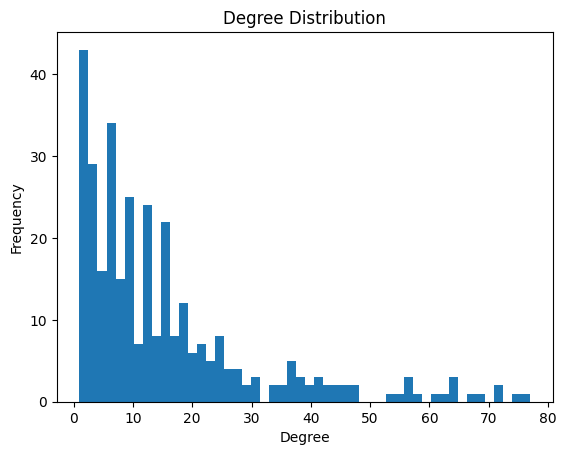

In [10]:
#Linear Scale Histogram
plot.degree_count_plot(G_lcc, logy=False)

From this plot i can already assume that there isn't a clear power-law distribution (multiple bumps beyond the initial sharp peak) and preferential attachment might not be the dominant generative feature in this particular ego network, without needing to perform the log-log plot to confirm it. 

I will still consider degree-based features, because could always be relevant as demonstrated in previous notebook.

### Node Features

In [11]:
# Filter the feature dataframe with the nodes in the LCC
lcc_feat_df = features_df[features_df.index.isin(G_lcc.nodes)]

In [12]:
lcc_feat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 324 entries, 1 to 347
Columns: 224 entries, birthday;anonymized feature 0 to work;with;id;anonymized feature 205
dtypes: int64(224)
memory usage: 569.5 KB


In [13]:
feature_frequency = lcc_feat_df.mean().sort_values(ascending=False)

print("-- Top 10 Most Frequent Features --")
print(feature_frequency.head(10))
print("\n-- Bottom 10 Top Frequent Features --")
print(feature_frequency.tail(10))

-- Top 10 Most Frequent Features --
locale;anonymized feature 127                       0.938272
education;type;anonymized feature 53                0.675926
gender;anonymized feature 78                        0.623457
education;type;anonymized feature 55                0.608025
education;school;id;anonymized feature 50           0.462963
gender;anonymized feature 77                        0.358025
education;type;anonymized feature 54                0.228395
education;concentration;id;anonymized feature 14    0.228395
education;year;id;anonymized feature 65             0.212963
languages;id;anonymized feature 92                  0.194444
dtype: float64

-- Bottom 10 Top Frequent Features --
work;end_date;anonymized feature 159       0.006173
work;location;id;anonymized feature 175    0.006173
work;start_date;anonymized feature 203     0.006173
work;position;id;anonymized feature 187    0.006173
work;position;id;anonymized feature 190    0.006173
work;position;id;anonymized feature 191 

Some features are extremely common or extremely rare and could not be valuable for link prediction (might not provide a valid indicator or might lack of discriminative power, respectively).

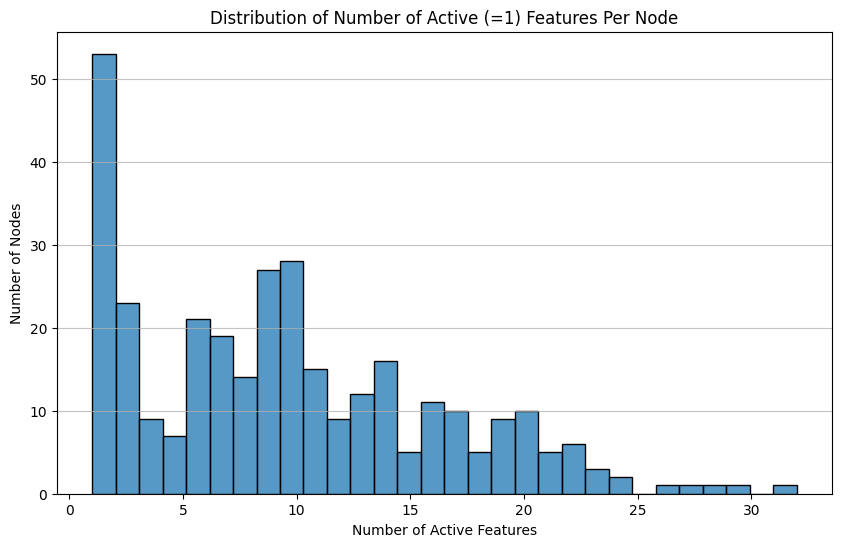

In [14]:
# Distribution of Number of Active (=1) Features per Node
num_active_features_per_node = lcc_feat_df.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.histplot(num_active_features_per_node, bins=30) #type: ignore
plt.title('Distribution of Number of Active (=1) Features Per Node')
plt.xlabel('Number of Active Features')
plt.ylabel('Number of Nodes')
plt.grid(axis='y', alpha=0.75)
plt.show()

Most nodes have very sparse feature vectors and few nodes have a rich feature profile (could be hubs).

Having the features represented with one-hot encoding it could be useful to group them to make further analysis.

In [15]:
feature_classes_values = {}

for full_feature_name in lcc_feat_df.columns:
    parts = full_feature_name.rsplit(';anonymized feature ', 1)

    feature_base_name = parts[0].strip()

    if feature_base_name not in feature_classes_values:
        feature_classes_values[feature_base_name] = 0
    feature_classes_values[feature_base_name]+=1

print("Length: ", len(feature_classes_values))
feature_classes_values

Length:  21


{'birthday': 8,
 'education;classes;id': 5,
 'education;concentration;id': 7,
 'education;degree;id': 4,
 'education;school;id': 29,
 'education;type': 3,
 'education;with;id': 1,
 'education;year;id': 16,
 'first_name': 4,
 'gender': 2,
 'hometown;id': 11,
 'languages;id': 14,
 'last_name': 21,
 'locale': 3,
 'location;id': 12,
 'work;employer;id': 20,
 'work;end_date': 16,
 'work;location;id': 12,
 'work;position;id': 13,
 'work;start_date': 22,
 'work;with;id': 1}

There are basic features like first name, last name and gender but also specialized features like the ones relative to education and work. <br>
The first thing that seems a bit off is the number of distinct values for some features, like `first_name` that has only 4. This is probably a result of the anonymization process, maybe through bucketing, but is indeed curious how they managed to fit all the first names into only 4 anonymized buckets. 

In [16]:
columns_grouped_by_feature_class = {}

for column_name in lcc_feat_df.columns:
    match = re.search(r';anonymized feature \d+$', column_name)

    if match:
        feature_base_name = column_name[:match.start()].strip()

    if feature_base_name not in columns_grouped_by_feature_class:
        columns_grouped_by_feature_class[feature_base_name] = []
    columns_grouped_by_feature_class[feature_base_name].append(column_name)

tmp_data = []

for feature_class, columns in columns_grouped_by_feature_class.items():
    count = lcc_feat_df[columns].sum(axis=1)

    no_actives = (count == 0).sum()
    at_least_one_active = (count > 0).sum()
    more_than_one_active = (count > 1).sum()

    tmp_data.append({
        'Feature Class': feature_class,
        'No Actives': no_actives,
        'At Least One Active': at_least_one_active,
        'More Than One Active': more_than_one_active
    })

feature_classes_actives = pd.DataFrame(tmp_data)
feature_classes_actives

,Feature Class,No Actives,At Least One Active,More Than One Active
0,birthday,229,95,0
1,education;classes;id,313,11,0
2,education;concentration;id,231,93,8
3,education;degree;id,303,21,4
4,education;school;id,111,213,56
5,education;type,81,243,202
6,education;with;id,322,2,0
7,education;year;id,131,193,127
8,first_name,314,10,0
9,gender,6,318,0


This table gives other valuable insights on what types of data this dataset had originally:
- Some feature classes are **exclusive** (birthday, first name, gender, ...) but others are not (languages, education type, work location, ...).
- Some feature classes have no active values (**no data**) for many nodes, confirming what already emerged while creating the dataframe.

Also, the last observation done on the first name values, could actually be *wrong*: the table showed that 314 out of 324 nodes have no data for the first name feature, potentially meaning that no bucketing has been made, and, given the high number of "**No Actives**" across all feature classes, this really seems to be the case of **data missingness**. *Why?*

Anyway, this table combined with the top and bottom most frequent features gives some strong indicators of which feature could be the most effective to select.

## Feature Selection

### Topological Features

In [17]:
def build_topological_feature_vector(pairs, G, features=['cn', 'jc', 'aa', 'pa', 'ra']):
    feature_data = {}

    if 'cn' in features:
        feature_data['cn'] = [len(list(nx.common_neighbors(G, u, v))) for u, v in pairs]

    if 'jc' in features:
        feature_data['jc'] = [coeff for _, _, coeff in nx.jaccard_coefficient(G, pairs)]

    if 'aa' in features:
        aa_scores = []
        for u_node, v_node in pairs:
            try:
                _, _, score = list(nx.adamic_adar_index(G, [(u_node, v_node)]))[0]
                aa_scores.append(score)
            except (ZeroDivisionError, StopIteration):
                aa_scores.append(0.0)
        feature_data['aa'] = aa_scores

    if 'pa' in features:
        feature_data['pa'] = [coeff for _, _, coeff in nx.preferential_attachment(G, pairs)]

    if 'ra' in features:
        feature_data['ra'] = [coeff for _, _, coeff in nx.resource_allocation_index(G, pairs)]

    # Combine feature
    feature_vectors = []
    for i in range(len(pairs)):
        vector = [feature_data[feat][i] for feat in features]
        feature_vectors.append(vector)

    return feature_vectors

The initial baseline will be formed by the 5 topological features already used in other notebooks.

In [18]:
# Features
topological_features = ['cn', 'jc', 'aa', 'pa', 'ra']

# Create training and testing sets
X_train, X_test, y_train, y_test = splits.create_train_test_split(
    G_lcc,
    lambda pairs, G_train_graph: build_topological_feature_vector(pairs, G_train_graph, topological_features),
    lambda: ns.common_neighbors_hard_negative_sampling(G_lcc)
)

---
Feature Scaling is a critical step for Logistic Regression. The weight learned by the model are directly influenced by the scale of the features, this makes the raw coefficients incomparable. The StandardScaler transform each feature to have a mean of 0 and a standard deviation of 1.

In [19]:
def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # type: ignore
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

---
Now two Logistic Regression models will be trained to compare two different types of regularization: L2 and L1.

In [20]:
#Scale the data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

In [21]:
# Train Logistic Regression with L2 Regularization
lr_l2 = LogisticRegression(penalty='l2', random_state=42, max_iter=1000)
lr_l2.fit(X_train_scaled, y_train)

y_pred_lr_l2 = lr_l2.predict_proba(X_test_scaled)[:, 1] # type: ignore
coeffs_lr_l2 = lr_l2.coef_[0]

print('Logistic Regression with L2 Regularization (Ridge)')
print('Features:     ', topological_features)
print('Coefficients: ', coeffs_lr_l2)
print(f'AUC-PR Score: {average_precision_score(y_test, y_pred_lr_l2):.4f}')

Logistic Regression with L2 Regularization (Ridge)
Features:      ['cn', 'jc', 'aa', 'pa', 'ra']
Coefficients:  [-0.66862857 -0.44571748  0.11018249 -0.19465749  1.89131588]
AUC-PR Score: 0.7571


In [22]:
# Train Logistic Regression with L1 Regularization
lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42, max_iter=1000)
lr_l1.fit(X_train_scaled, y_train)

y_pred_lr_l1 = lr_l1.predict_proba(X_test_scaled)[:, 1] # type: ignore
coeffs_lr_l1 = lr_l1.coef_[0]

print('Logistic Regression with L1 Regularization (Lasso)')
print('Features:     ', topological_features)
print('Coefficients: ', coeffs_lr_l1)
print(f'AUC-PR Score: {average_precision_score(y_test, y_pred_lr_l1):.4f}')

Logistic Regression with L1 Regularization (Lasso)
Features:      ['cn', 'jc', 'aa', 'pa', 'ra']
Coefficients:  [-0.58162816 -0.32394267  0.         -0.1197314   1.73955328]
AUC-PR Score: 0.7593


The results from the two models reveals that:
- L2 (Ridge): This model achieved an AUC-PR of ~0.76. It kept all five features but produced counter-intuitive negative coefficients for `cn`, `jc`, and `pa`. This is a symptom of **multicollinearity**, where the model is confused by the redundant information in the features and cannot assign stable, meaningful weights.
- L1 (Lasso): This model achieved a similar score. However, it has set the coefficient for `aa` to exactly *0.0*. This happens because, given the other features, `aa` is the most redundant and can be removed without harming performance.

This comparison strongly suggests that our feature set is too complex and redundant for a linear model.

---

To confirm the obtained results and the diagnosis made, we can try to train a Random Forest and see the feature importance scores.

In [23]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
auc_pr_rf = average_precision_score(y_test, y_pred_rf)

print('Random Forest')
print('Features:     ', topological_features)
print('Importances:  ', rf.feature_importances_)
print(f'AUC-PR Score: {average_precision_score(y_test, y_pred_rf):.4f}')

Random Forest
Features:      ['cn', 'jc', 'aa', 'pa', 'ra']
Importances:   [0.06605142 0.18098669 0.22225856 0.22820369 0.30249964]
AUC-PR Score: 0.8116


The Random Forest model results support the findings:
- The AUC-PR score is higher than Logistic Regression models proving the features are valuable when used by a suitable model.
- The importances clearly show that Resource Allocation (`ra`) is the single most powerful predictor.
---

Given that in all trained models `ra` has resulted the best predictor and is also the only one that has a positive coefficient with L1 regularization, we can opt to select this single feature for the final model.

In [24]:
# Features
topological_features = ['ra']

# Create training and testing sets
X_train, X_test, y_train, y_test = splits.create_train_test_split(
    G_lcc,
    lambda pairs, G_train_graph: build_topological_feature_vector(pairs, G_train_graph, topological_features),
    lambda: ns.common_neighbors_hard_negative_sampling(G_lcc)
)

# Scale the data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

In [25]:
# Train Logistic Regression
lr_l2 = LogisticRegression(random_state=42, max_iter=1000)
lr_l2.fit(X_train_scaled, y_train)

y_pred_lr_l2 = lr_l2.predict_proba(X_test_scaled)[:, 1] # type: ignore
coeffs_lr_l2 = lr_l2.coef_[0]

print('Logistic Regression with L2 Regularization (Ridge)')
print('Features:     ', topological_features)
print('Coefficients: ', coeffs_lr_l2)
print(f'AUC-PR Score: {average_precision_score(y_test, y_pred_lr_l2):.4f}')

Logistic Regression with L2 Regularization (Ridge)
Features:      ['ra']
Coefficients:  [0.95251243]
AUC-PR Score: 0.7623


As expected the single-feature Linear Regression model obtained a slightly higher score than the previous models, so, as topological feature, only `ra` is selected.

---

### Node Features

With 224 features and only 324 nodes, the model has a high risk of overfitting instead of learning true patterns.

We can start by removing features classes that are present in very few nodes, because are unlikely to generalize well.

In [26]:
heuristic_threshold = 0.95 # Searching for feature classes that have this percentage of 'No Actives' values (over the total entries)

tmp = feature_classes_actives[feature_classes_actives['No Actives']>(lcc_feat_df.shape[0] * heuristic_threshold)]
features_classes_to_remove = tmp['Feature Class']

columns_to_remove = [col for col in lcc_feat_df.columns if any(col.startswith(prefix) for prefix in features_classes_to_remove)]

selected_features_df = lcc_feat_df.drop(columns=columns_to_remove)

print('Removed columns: ', len(columns_to_remove))
columns_to_remove

Removed columns:  11


['education;classes;id;anonymized feature 8',
 'education;classes;id;anonymized feature 9',
 'education;classes;id;anonymized feature 10',
 'education;classes;id;anonymized feature 11',
 'education;classes;id;anonymized feature 12',
 'education;with;id;anonymized feature 56',
 'first_name;anonymized feature 73',
 'first_name;anonymized feature 74',
 'first_name;anonymized feature 75',
 'first_name;anonymized feature 76',
 'work;with;id;anonymized feature 205']

Some columns have been removed: we can be almost certain that those feature will not improve the model prediction and would probably have added some noise.

---

To enable our model to predict a link between a pair of nodes, we must convert their individual node feature vectors into a single combined feature vector. After some testing the choice of the combination technique falls on **L1 Distance (Manhattan Distance)** that calculates a vector where each element is 1 if the nodes disagree on a specific attribute and 0 if they agree (**homophily**).

In [27]:
def build_combined_feature_vector(pairs, G, feature_df, topological_features=[]):
    feature_vectors = []

    for u, v in pairs:
        topological_features_vector = build_topological_feature_vector([(u, v)], G, features=topological_features)[0]

        # L1 Distance (Manhattan Distance)
        features_u = feature_df.loc[u]
        features_v = feature_df.loc[v]
        node_pair_vector = np.abs(features_u - features_v).tolist()

        # Combine Topological and Node features vectors
        combined_vector = topological_features_vector + node_pair_vector
        feature_vectors.append(combined_vector)

    return feature_vectors

In [28]:
# Create training and testing sets
X_train, X_test, y_train, y_test = splits.create_train_test_split(
    G_lcc,
    lambda pairs, G_train_graph: build_combined_feature_vector(pairs, G_train_graph, selected_features_df, topological_features=['ra']),
    lambda: ns.common_neighbors_hard_negative_sampling(G_lcc)
)

# Scale the data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

The features can be selected more by using L1 Regularization: the features that gets coefficients =0 are excluded.

In [29]:
# Train Logistic Regression with L1 Regularization
l1_selector = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42, max_iter=1000)
l1_selector.fit(X_train_scaled, y_train)

# Get the features with non-zero coefficients
l1_coeffs = l1_selector.coef_[0]
feature_names = topological_features + selected_features_df.columns.tolist()
important_features_l1 = pd.DataFrame({
    'feature': feature_names,
    'coefficient': l1_coeffs
}).query('coefficient != 0').sort_values('coefficient', key=abs, ascending=False)

y_pred_l1_selector = l1_selector.predict_proba(X_test_scaled)[:, 1]

print('Logistic Regression with L1 Regularization')
print(f'AUC-PR Score:  {average_precision_score(y_test, y_pred_l1_selector):.4f}')
print(f'Features sorted by absolute value of coefficient (Total features: {important_features_l1.shape[0]}): ')
print(important_features_l1.head(15))

Logistic Regression with L1 Regularization
AUC-PR Score:  0.7865
Features sorted by absolute value of coefficient (Total features: 140): 
                                       feature  coefficient
0                                           ra     0.884041
199     work;start_date;anonymized feature 162     0.252371
149    work;employer;id;anonymized feature 155    -0.197752
194     work;start_date;anonymized feature 195     0.166460
170    work;location;id;anonymized feature 132    -0.158082
68                gender;anonymized feature 77    -0.133408
182    work;position;id;anonymized feature 184    -0.122653
166       work;end_date;anonymized feature 172    -0.121451
27   education;school;id;anonymized feature 31     0.113245
126         location;id;anonymized feature 135    -0.106955
2                birthday;anonymized feature 1     0.101330
31   education;school;id;anonymized feature 35     0.100765
42   education;school;id;anonymized feature 46    -0.099978
32   education;school;

From this model we can note that:
- The AUC-PR score has improved.
- Another good chunk of features can be removed as they have got a coefficient equal to zero. 
- Only few feature have a significant weight, with `ra` being dominant.

---
We can again compare the results with a Random Forest. 

In [30]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Get the features importance
important_features_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]

print('Random Forest')
print(f'AUC-PR Score: {average_precision_score(y_test, y_pred_rf):.4f}')
print('Features sorted by absolute value of coefficient: ')
print(important_features_rf.head(15))

Random Forest
AUC-PR Score: 0.7570
Features sorted by absolute value of coefficient: 
                                              feature  importance
0                                                  ra    0.273225
68                       gender;anonymized feature 77    0.019289
69                       gender;anonymized feature 78    0.018368
129                location;id;anonymized feature 137    0.017214
123                location;id;anonymized feature 132    0.013802
54            education;year;id;anonymized feature 59    0.013015
49               education;type;anonymized feature 53    0.012948
46          education;school;id;anonymized feature 50    0.012841
83                 languages;id;anonymized feature 92    0.012671
51               education;type;anonymized feature 55    0.011934
10   education;concentration;id;anonymized feature 14    0.011886
8                       birthday;anonymized feature 7    0.011744
103                  last_name;anonymized feature 112   

The Random Forest feature importances were consistent with the Logistic Regression coefficients, by highlighting the dominance of `ra` as predictive feature.

However, while the Logistic Regression improved its score, the Random Forest lost some points and got a lower score than Logistic Regression. This could have caused by the Random Forest feature subsampling: selecting a random set of feature to create each decision tree, while having only few features that are strong predictors resulted in many trees built with only weak and noisy features, and their poor results averaged in the final result, degrading the overall score.

---
The next step is trying to remove the features that received a 0 coefficient form L1 Regularization.

In [31]:
# Threshold variable for testing different values
coefficient_threshold = 0.0

# Select features with absolute coefficient > coefficient_threshold
selected_features = important_features_l1[
    abs(important_features_l1['coefficient']) > coefficient_threshold
]['feature'].tolist()

# Split Topological features from Node features
selected_topological_features = [f for f in selected_features if f in topological_features]
selected_node_features = [f for f in selected_features if f in selected_features_df.columns]
selected_node_features_df = selected_features_df[selected_node_features]

print(f'Selected {len(selected_features)} features with absolute coefficient > {coefficient_threshold}')

Selected 140 features with absolute coefficient > 0.0


In [32]:
# Create the new training and testing sets using only the champion features
X_train, X_test, y_train, y_test = splits.create_train_test_split(
    G_lcc,
    lambda pairs, G_train_graph: build_combined_feature_vector(
        pairs,
        G_train_graph,
        selected_node_features_df,
        topological_features=selected_topological_features
    ),
    lambda: ns.common_neighbors_hard_negative_sampling(G_lcc)
)

# Scale the data
X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

In [33]:
# Train Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

y_pred_final = lr.predict_proba(X_test_scaled)[:, 1]
auc_pr_final = average_precision_score(y_test, y_pred_final)

print('Logistic Regression')
print(f'AUC-PR Score: {auc_pr_final:.4f}')

Logistic Regression
AUC-PR Score: 0.8070


## Conclusions

The analysis made in this notebook is a form of **ablation study**, here's all results obtained:

| **Model Type** | **Feature Set** | **AUC-PR Score** | **Notes** |
|----------------|-----------------|------------------|-----------| 
| **Logistic Regression (L2)** | All 5 topological features | 0.7571 | The baseline to test the difference between L1/L2 Regularization and choose the best topological features |
| **Logistic Regression (L1)** | All 5 topological features | 0.7593 | Confirmed multicollinearity by setting the `aa` coefficient to zero. |
| **Random Forest** | All 5 topological features | 0.8116 | *Highest overall score.* Proved the features are valuable when used by a model robust to multicollinearity. |
| **Logistic Regression (L2)** | `ra` (L1-selected) | 0.7623 | Showed that a single topological feature could match the performance of all five, confirming feature redundancy. |
| **Logistic Regression (L1)**  | `ra` + 224 node features (heuristic-selected) | 0.7865 | The addition of node features provided a performance boost over topology alone. |
| **Random Forest** | `ra` + 224 node features (heuristic-selected) | 0.7570 | Performed worse than its LR counterpart, suggesting the node features added more noise than useful signal for the ensemble. |
| **Logistic Regression (L2)**  | `ra` + 140 node features (L1-selected)| 0.8070 | *Best LR Score.* Removing noisy features with L1 allowed the model to achieve its peak performance, almost matching the best RF score. |


The first models highlighted how strong topological features are, especially when combined with a model robust to multicollinearity. However, the addition of node features helped to narrow the gap between a linear (LR) and a non-linear classifier (RF), by adding small, but still, valuable information. At the same time can also be noted that Random Forest lowered it's score, resulted being even lower than Logistic Regression with the combination of topological and node features (as already explained).

The most significant performance gains came from a multi-stage feature selection process:
1. Started with 224 node features
2. Applied a simple heuristic to remove sparse features.
3. Used multiple times L1 Regularization to automatically identify the ~140 topological and node features with the most predictive power.

This analysis demonstrated that the choice of the model is as important and impactful as the feature engineering process.